### For loops to pull L2A, L2B, L4A as needed

In [1]:
!pip install geopandas
!pip install contextily

  Using cached contextily-1.6.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
Using cached contextily-1.6.2-py3-none-any.whl (17 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
Using cached geographiclib-2.0-py3-none-any.whl (40 kB)


In [2]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.maap-project.org')

def job_status_for(job_id: str) -> str:
    response = maap.getJobStatus(job_id)
    response.raise_for_status()
   
    root = ET.fromstring(response.text)
    status_element = root.find('.//{http://www.opengis.net/wps/2.0}Status')
   
    return status_element.text

def job_result_for(job_id: str) -> str:
    response = maap.getJobResult(job_id)
    response.raise_for_status()
   
    root = ET.fromstring(response.text)

    return root.find('.//{http://www.opengis.net/wps/2.0}Data').text

def to_job_output_dir(job_result_url: str) -> str:
    url_path = urlparse(job_result_url).path
    # The S3 Key is the URL path excluding the `/{username}` prefix
    s3_key = "/".join(url_path.split("/")[2:])

    return f"/projects/my-private-bucket/{s3_key}"

def wait_for_job(job_id: str) -> str:
    return job_status_for(job_id)

In [3]:
#pip install geopandas
#pip install shapely
#Import numpy for making column inputs easier
import numpy as np
import geopandas as gpd
import backoff
import shapely
import glob
import os

In [4]:
import xml.etree.ElementTree as ET
from urllib.parse import urlparse

def job_status_for(job_id: str) -> str:
    response = maap.getJobStatus(job_id)
    response.raise_for_status()
    
    root = ET.fromstring(response.text)
    status_element = root.find('.//{http://www.opengis.net/wps/2.0}Status')
    
    return status_element.text

def job_result_for(job_id: str) -> str:
    response = maap.getJobResult(job_id)
    response.raise_for_status()
    
    root = ET.fromstring(response.text)

    return root.find('.//{http://www.opengis.net/wps/2.0}Data').text

def to_job_output_dir(job_result_url: str) -> str:
    url_path = urlparse(job_result_url).path
    # The S3 Key is the URL path excluding the `/{username}` prefix
    s3_key = "/".join(url_path.split("/")[2:])

    return f"/projects/my-private-bucket/{s3_key}"

In [4]:
import geopandas as gpd
import os

# Function to split a GeoPackage into individual files
def split_geopackage(input_file, output_dir):
    # Read the GeoPackage
    gdf = gpd.read_file(input_file)
    
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Loop through each feature and save it as a separate file
    for idx, row in gdf.iterrows():
        # Create a GeoDataFrame for the individual feature
        single_feature_gdf = gpd.GeoDataFrame([row], columns=gdf.columns, geometry=gdf.geometry)
        
        # Define output file path
        output_file = os.path.join(output_dir, f"feature_{idx + 1}.gpkg")
        
        # Write the single feature to a new GeoPackage file
        single_feature_gdf.to_file(output_file, driver="GPKG")
        print(f"Feature {idx + 1} saved to {output_file}")

# Example usage
input_geopackage = '/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/GRID_all_tiles_with_data.gpkg'  # Replace with your input GeoPackage file
output_directory = '/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID'        # Directory to save individual feature files

split_geopackage(input_geopackage, output_directory)

Feature 1 saved to /projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/feature_1.gpkg
Feature 2 saved to /projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/feature_2.gpkg
Feature 3 saved to /projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/feature_3.gpkg
Feature 4 saved to /projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/feature_4.gpkg
Feature 5 saved to /projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/feature_5.gpkg
Feature 6 saved to /projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/feature_6.gpkg
Feature 7 saved to /projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/feature_7.gpkg
Feature 8 saved to /projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/feature_8.gpkg
Feature 9 saved to /projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/feature_9.gpkg
Feature 10 saved to /projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/feature_10.gpkg
Feature 11 saved to /projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/

In [ ]:
folder_path = "/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data"
json_files = []
pattern = os.path.join(folder_path, 'AOI*.gpkg')
json_files = glob.glob(pattern)
json_files = [ x for x in json_files if "L2A" not in x ]
json_files = [x.replace('/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/',
                        'https://maap-ops-workspace.s3.amazonaws.com/shared/nehajo88/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/') for x in json_files]
print(len(json_files))
print(json_files)
AOIs = json_files
AOIs
# folder_path = "/projects/my-public-bucket/Data/NASA_CMS_2023/WA_15_countries/GRID_Mali/"
# json_files = []
# pattern = os.path.join(folder_path, '*.gpkg')
# json_files = glob.glob(pattern)
# json_files = [ x for x in json_files if "L2A" not in x ]
# json_files = [x.replace('/projects/my-public-bucket/Data/NASA_CMS_2023/WA_15_countries/GRID_Mali/',
#                         'https://maap-ops-workspace.s3.amazonaws.com/shared/nehajo88/Data/NASA_CMS_2023/WA_15_countries/GRID_Mali/') for x in json_files]
# print(len(json_files))
# print(json_files)
# AOIs = json_files
# AOIs

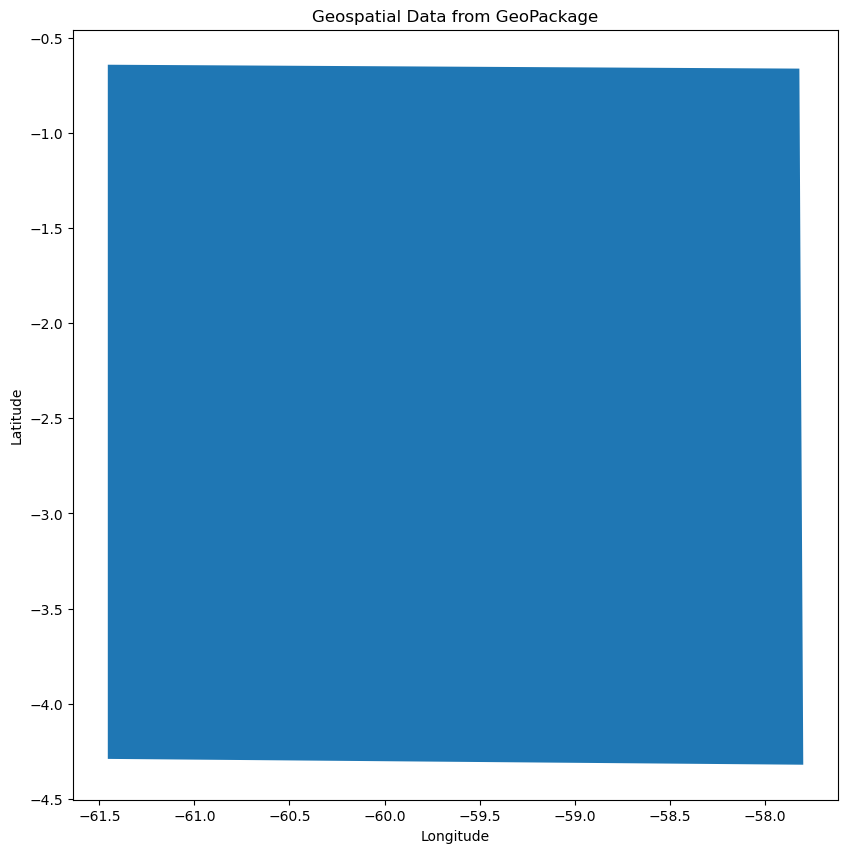

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Read the GeoPackage file
gdf = gpd.read_file('/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/AOI.gpkg')

# Step 2: Plot the data
gdf.plot(figsize=(10, 10))  # You can adjust the size of the plot

# Optional: Customize plot (e.g., add a title)
plt.title('Geospatial Data from GeoPackage')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [25]:
#Set up run to pull products for all GEDI products simultaneously #To run for only 1 or 2 products, change "PRODUCTS"

PRODUCTS = ["L4A"] # ,"L2A","L2B"]  #To run for only 1 or 2 products, change "PRODUCTS"
out_dir = "/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/"
if not os.path.exists(out_dir): os.mkdir(out_dir)

AOIs = json_files
#AOIs = [AOIs[2]]

for each_aoi in AOIs: 
    if "L4A" in PRODUCTS: 
        if not os.path.exists(out_dir + f"{os.path.basename(each_aoi).split('.')[0]}_MON_L4A.gpkg"):
            aoi_name = os.path.basename(each_aoi).split('.')[0]
            print(f"Thanks, I'll run the GEDI L4A subsetter for {aoi_name}!!")
            #aoi_url = each_aoi
            inputs = dict(
               aoi=each_aoi,
               doi="L4A",
               lat="lat_lowestmode",
               lon="lon_lowestmode",
               beams="all",
               columns="shot_number,lat_lowestmode,lon_lowestmode,elev_lowestmode,agbd,agbd_se,agbd_t,agbd_t_se,sensitivity,geolocation/sensitivity_a2",
               query="l2_quality_flag == 1 and l4_quality_flag == 1 and sensitivity > 0.95", #  and geolocation/sensitivity_a2 > 0.95",
               # limit = 100000,
               #temporal="-",
               output=f"{os.path.basename(each_aoi).split('.')[0]}_MON_L4A.gpkg"
            )
            result = maap.submitJob(
                identifier="gedi-subset",
                algo_id="gedi-subset",
                version="0.9.0",
                queue="maap-dps-worker-32vcpu-64gb",
                username="nehajo88",
                **inputs
            )
            inputs
            job_id = result.id
            job_id or result

    if "L2B" in PRODUCTS: 
        if not os.path.exists(out_dir + f"{os.path.basename(each_aoi).split('.')[0]}_MON_L2B.gpkg"):
            aoi_name = os.path.basename(each_aoi).split('.')[0]
            print(f"Thanks, I'll run the GEDI L2B subsetter for {aoi_name}!!")
            #aoi_url = each_aoi
            inputs = dict(
               aoi=each_aoi,
               doi="L2B",
               lat="geolocation/lat_lowestmode",
               lon="geolocation/lon_lowestmode",
               beams="all",
               columns="shot_number,geolocation/lon_lowestmode,geolocation/lat_lowestmode,rh100,l2b_quality_flag,sensitivity,cover,land_cover_data/landsat_treecover, pai,fhd_normal,"+",".join(variables),
               query="l2a_quality_flag == 1 and l2b_quality_flag == 1 and sensitivity > 0.95",
               limit = 100000,
               #temporal="-",
               output=f"{os.path.basename(each_aoi).split('.')[0]}_MON_L2B.gpkg"
            )
            result = maap.submitJob(
                identifier="gedi-subset",
                algo_id="gedi-subset",
                version="0.9.0",
                queue="maap-dps-worker-32vcpu-64gb",
                username="nehajo88",
                **inputs
            )
            inputs
            job_id = result.id
            job_id or result
        
        
    if "L2A" in PRODUCTS: 
        if not os.path.exists(out_dir + f"{os.path.basename(each_aoi).split('.')[0]}_MON_L2A.gpkg"):
            aoi_name = os.path.basename(each_aoi).split('.')[0]
            print(f"Thanks, I'll run the GEDI L2A subsetter for {aoi_name}!!")
            #aoi_url = each_aoi
            inputs = dict(
               aoi=each_aoi,
               doi="L2A",
               lat="lat_lowestmode",
               lon="lon_lowestmode",
               beams="all",
               columns="shot_number,lon_lowestmode,lat_lowestmode,rh10,rh20,rh30,rh40,rh50,rh60,rh70,rh80,rh90,rh98,quality_flag,sensitivity",
               # columns="shot_number,lon_lowestmode,lat_lowestmode,rh10,rh20,rh30,rh40,rh50,rh60,rh70,rh80,rh90,rh98,quality_flag,rx_processing_a2/rx_algrunflag,rx_processing_a2/zcross,rx_processing_a2/toploc,geolocation/sensitivity_a2,degrade_f",
               #columns="all",
               query="quality_flag == 1 and sensitivity > 0.95",
               limit = 100000,
               #temporal="-",
               output=f"{os.path.basename(each_aoi).split('.')[0]}_MON_L2A.gpkg"
            )
            result = maap.submitJob(
                identifier="gedi-subset",
                algo_id="gedi-subset",
                version="0.9.0",
                queue="maap-dps-worker-32gb",
                username="nehajo88",
                **inputs
            )
            inputs
            job_id = result.id
            job_id or result
        

Thanks, I'll run the GEDI L4A subsetter for AOI!!


In [8]:
import subprocess

root_dir = "/projects/my-private-bucket/dps_output/gedi-subset/0.9.0/gedi-subset/2025/02/25"  # Can now set name
out_dir = "/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI/"

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

for dirName, subdirList, fileList in os.walk(root_dir):
#    print("Found directory: %s" % dirName)
    for fname in fileList:
        if fname.startswith("feature_") and fname.endswith("_MON_L4A.gpkg"):
#        if fname.endswith("NPAs_L4A.gpkg"):
            source_path = os.path.join(dirName, fname)
            print(source_path)
            target_path = os.path.join(out_dir, fname)
            print(target_path)
            if not os.path.exists(target_path):  # Check if file doesn’t exist in target directory
                print(f"Moving {fname}...")
                subprocess.call(['mv', source_path, target_path])
            else:
                print(f"{fname} already exists in the target directory. Skipping...")

/projects/my-private-bucket/dps_output/gedi-subset/0.9.0/gedi-subset/2025/02/25/17/51/09/413880/feature_330_MON_L4A.gpkg
/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI/feature_330_MON_L4A.gpkg
feature_330_MON_L4A.gpkg already exists in the target directory. Skipping...
/projects/my-private-bucket/dps_output/gedi-subset/0.9.0/gedi-subset/2025/02/25/17/53/24/733940/feature_117_MON_L4A.gpkg
/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI/feature_117_MON_L4A.gpkg
feature_117_MON_L4A.gpkg already exists in the target directory. Skipping...
/projects/my-private-bucket/dps_output/gedi-subset/0.9.0/gedi-subset/2025/02/25/17/53/26/640879/feature_138_MON_L4A.gpkg
/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI/feature_138_MON_L4A.gpkg
feature_138_MON_L4A.gpkg already exists in the target directory. Skipping...


In [ ]:
import rasterio
import os
import argparse
from rasterio.io import MemoryFile
from rasterio.rio import options
from rasterio.shutil import copy, delete
from rasterio.vrt import WarpedVRT
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from rasterio.transform import from_origin
from rasterio.crs import CRS
import pandas as pd
import geopandas as gpd
import numpy as np

FOLDER = "/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/"
OUT_FOLDER = "/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/"

for dirName, subdirList, fileList in os.walk(FOLDER):
    for fname in fileList:
        if fname.endswith("_MON_L4A.gpkg") and fname.__contains__("ADM1_PT_M"):
            OUTFILE = os.path.join(OUT_FOLDER, fname.split('.')[0] + '.tif')
            print(OUTFILE)
                
            if not os.path.exists(OUTFILE): 
                L4A = gpd.read_file(os.path.join(FOLDER, fname))
                L4A = L4A.drop('geometry', axis=1)
                
                x = L4A["lon_lowestmode"]
                y = L4A["lat_lowestmode"]
                z = L4A.agbd
                # z[z == 0] = np.nan  # Replace 0 values with NaN for 'no data' handling
                
                pixel_width = 0.005  # units in degrees
                pixel_height = 0.005  # units in degrees
                
                nx = int(np.round((np.max(x) - np.min(x)) / pixel_width))  # x size of output raster
                ny = int(np.round((np.max(y) - np.min(y)) / pixel_width))  # y size of output raster
                
                zi, yi, xi = np.histogram2d(y, x, bins=(ny, nx), weights=z)
                counts, _, _ = np.histogram2d(y, x, bins=(ny, nx))
                
                # Calculate mean value (avoid divide by 0 errors)
                zi = np.divide(zi, counts, out=np.zeros_like(zi), where=counts != 0)
                
                # Reverse array to match coordinate system
                z = np.array(zi.data[::-1])
                
                # Set NaN values to 0 in the array (nodata handling)
                z[np.isnan(z)] = 0  # Replace NaN values with 0

                pixel_width = xi[1] - xi[0]  # Approximate pixel width
                pixel_height = yi[1] - yi[0]  # Approximate pixel height
                x_min = xi[0]
                y_max = yi[-1]
                
                transform = from_origin(x_min, y_max, pixel_width, pixel_height)
                crs = CRS.from_epsg(4326)
                
                kwargs = {
                    'driver': 'GTiff',
                    'dtype': z.dtype,
                    'count': 1,  # Number of bands
                    'height': z.shape[0],
                    'width': z.shape[1],
                    'crs': crs,
                    'transform': transform,
                    'predictor': 2,
                    'nodata': 0  # Set the nodata value to 0
                }
                
                with MemoryFile() as memfile:
                    with memfile.open(**kwargs) as mem:
                        # Write data with 'nodata' set to 0
                        mem.write(z.reshape(1, z.shape[0], z.shape[1]))
                
                        dst_profile = cog_profiles.get("deflate")
                        cog_translate(
                            mem,
                            OUTFILE,
                            dst_profile,
                            in_memory=False
                        )
                
                print("GeoTIFF has been created successfully with GDAL.")
            else:
                print("GeoTIFF exists")

/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/ADM1_PT_Maranhao_MON_L4A.tif
GeoTIFF exists
/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/ADM1_PT_Mato_Grosso_1_MON_L4A.tif
